In [1]:
import os 
import sys
import glob
from tqdm import tqdm

import numpy as np 
import matplotlib.pyplot as plt 

import MDAnalysis as mda
from MDAnalysis.analysis import align
from MDAnalysis.analysis import distances
from MDAnalysis.analysis.rms import rmsd, RMSD

In [2]:
ref_pdb = '../../inputs/1KBH.pdb'
pdb_files = sorted(glob.glob('../../inputs/input_0*/prot.pdb'))
traj_files = sorted(glob.glob('../../md_runs/input_00*/prod_md/mdcrd'))

In [3]:
actr_sel = 'protein and resnum 1-47' 
ncbd_sel = 'protein and resnum 48-106' 
for traj_file, pdb_file in zip(traj_files, pdb_files): 
    pdb_traj = os.path.dirname(traj_file) + '/protein.dcd'
    pdb = os.path.dirname(traj_file) + '/protein.pdb'
    mda_traj = mda.Universe(pdb_file, traj_file, format='NC')
    protein = mda_traj.select_atoms('protein') 
    ncbd_traj = mda_traj.select_atoms(ncbd_sel)
    actr_traj = mda_traj.select_atoms(actr_sel)
    protein.write(pdb)
    with mda.Writer(pdb_traj, protein.n_atoms) as W: 
        for ts in tqdm(mda_traj.trajectory): 
            box_edge = ts.dimensions[0]
            box_center = np.array([1/6, 1/6*np.sqrt(2), 1/6*np.sqrt(6)]) * box_edge
            trans_vec = box_center - np.array(ncbd_traj.center_of_mass())
            protein.atoms.translate(trans_vec).wrap()
            W.write(protein)

100%|██████████| 40000/40000 [00:54<00:00, 733.57it/s]


In [4]:
pdb_files = sorted(glob.glob('../../md_runs/input_00*/prod_md/protein.pdb'))
traj_files = sorted(glob.glob('../../md_runs/input_00*/prod_md/protein.dcd'))

In [6]:
rmsd_profs = [] 
dist_profs = [] 
ref_traj = mda.Universe(ref_pdb)
ref_ca = ref_traj.select_atoms('protein and name CA')
actr_sel = 'protein and resnum 1-47' 
ncbd_sel = 'protein and resnum 48-106' 
for traj_file, pdb_file in zip(traj_files, pdb_files): 
#     print("Loaded strcture and run RMSD ")
    mda_traj = mda.Universe(pdb_file, traj_file) 
#     print(pdb_file, traj_file)
    protein = mda_traj.select_atoms('protein')
    ncbd_traj = mda_traj.select_atoms(ncbd_sel)
    actr_traj = mda_traj.select_atoms(actr_sel)
    rmsd_inst = RMSD(mda_traj, ref_traj, select='protein and name CA', verbose=True) 
    rmsd_inst.run() 
    rmsd_profs.append(rmsd_inst.rmsd)
#     dist = []
#     for ts in tqdm(mda_traj.trajectory[:]): 
#         trans_vec = np.array(ts.dimensions[:3])/2 - np.array(ncbd_traj.center_of_mass())
# #         print(protein.center_of_mass())
#         protein.atoms.translate(trans_vec).wrap()
#         print(protein.center_of_mass())
#         pro_ca = protein.select_atoms('name CA')
#         rmsd_inst = rmsd(pro_ca.positions, ref_ca.positions, superposition=1)
#         dist_map = distances.distance_array(ncbd_traj.positions, actr_traj.positions,  box=ncbd_traj.dimensions)
#         dist.append([ts.time, np.min(dist_map)])
#         rmsd_traj.append([ts.time, rmsd_inst])
    rmsd_profs.append(rmsd_inst)
    dist_profs.append(dist)
    
rmsd_profs = np.array(rmsd_profs)
dist_profs = np.array(dist_profs)

../../md_runs/input_0000/prod_md/protein.pdb ../../md_runs/input_0000/prod_md/protein.dcd


RMSD 13.19 A at frame 40000/40000  [100.0%]
  1%|          | 251/40000 [00:14<34:42, 19.09it/s]

KeyboardInterrupt: 

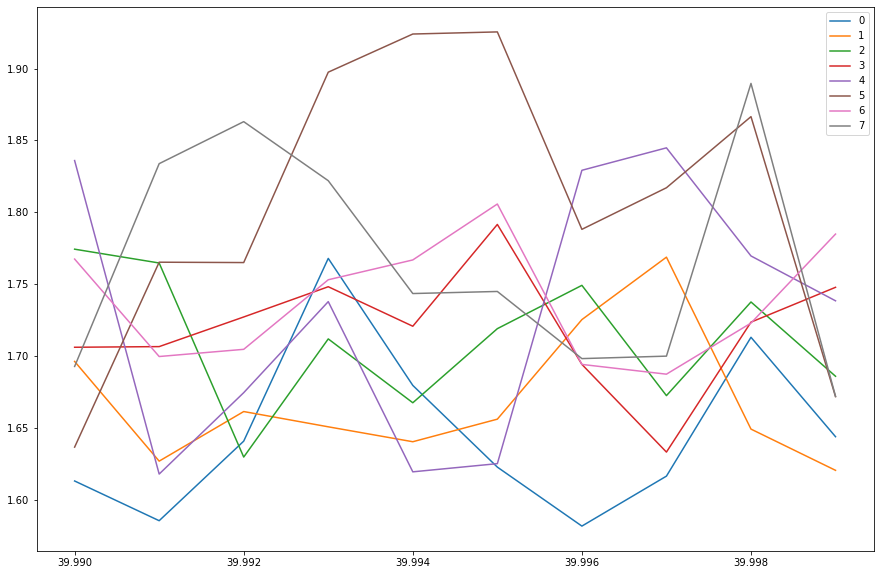

In [11]:
fig, ax = plt.subplots(figsize=(15,10)) 
n_traj = 0 

for j, dist_inst in enumerate(dist_profs): 
    ax.plot(dist_inst[:,0]/1000, dist_inst[:,1], label=j) 
plt.legend()
plt.savefig('dist.pdf')

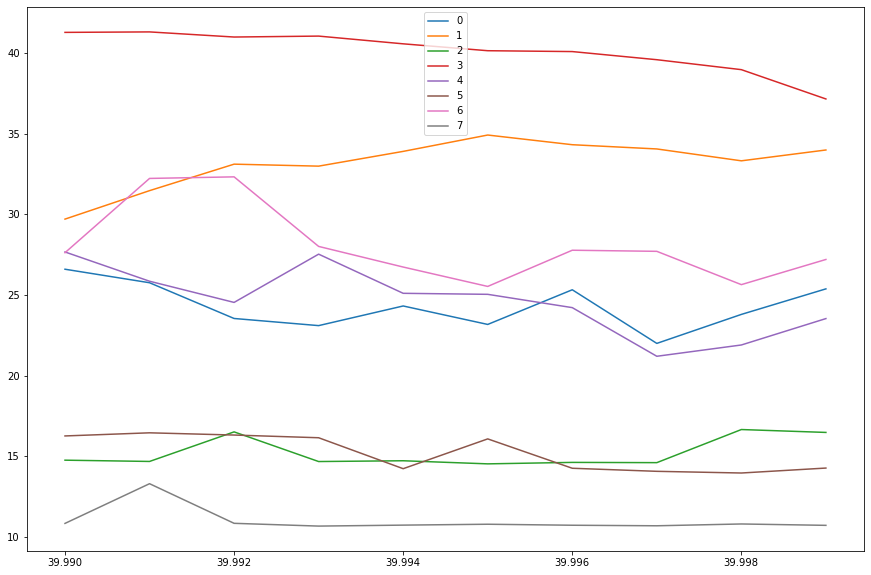

In [12]:
fig, ax = plt.subplots(figsize=(15,10)) 
n_traj = 0 

for j, rmsd_inst in enumerate(rmsd_profs): 
    ax.plot(rmsd_inst[:,0]/1000, rmsd_inst[:,1], label=j) 
plt.legend()
plt.savefig('rmsd.pdf')

AttributeError: 'numpy.ndarray' object has no attribute 'rmsd'

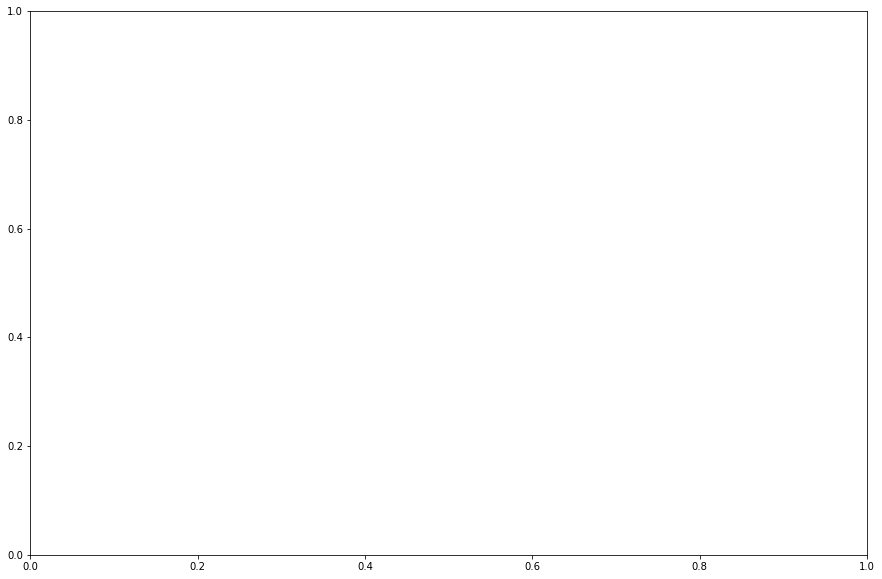

In [17]:
fig, ax = plt.subplots(figsize=(15,10)) 
n_traj = 0 

for j, rmsd_inst in enumerate(rmsd_profs): 
    ax.plot(rmsd_inst[:,1]/1000, rmsd_inst[:,2], label=j) 
plt.legend()
plt.savefig('rmsd.pdf')

In [6]:
np.save('rmsd.npy', rmsd_profs) 

In [6]:
%run ~/.matplotlib.py

In [7]:
frame_mini_RMSD = np.argmin(np.vstack(rmsd_profs)[:,2])

print np.min(np.vstack(rmsd_profs)[:,2])

traj_dict = {}
for traj_file in tqdm(sorted(traj_files[:])): 
    mda_traj = mda.Universe(pdb_file, traj_file) 
    traj_dict[traj_file] = len(mda_traj.trajectory)

from utils import find_frame, write_pdb_frame 
frame_mini_RMSD = np.argmin(np.vstack(rmsd_profs)[:,2])
traj_frame = find_frame(traj_dict, frame_mini_RMSD) 
print traj_frame

write_pdb_frame(traj_frame[0], pdb_file, traj_frame[1], 'low_RMSD.pdb')

 43%|████▎     | 27/63 [00:00<00:00, 131.58it/s]

0.4989168774386229


100%|██████████| 63/63 [00:00<00:00, 128.87it/s]


('../2F4K-0-protein/2F4K-0-protein-054.dcd', 734)


'low_RMSD.pdb'

/Users/hm/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


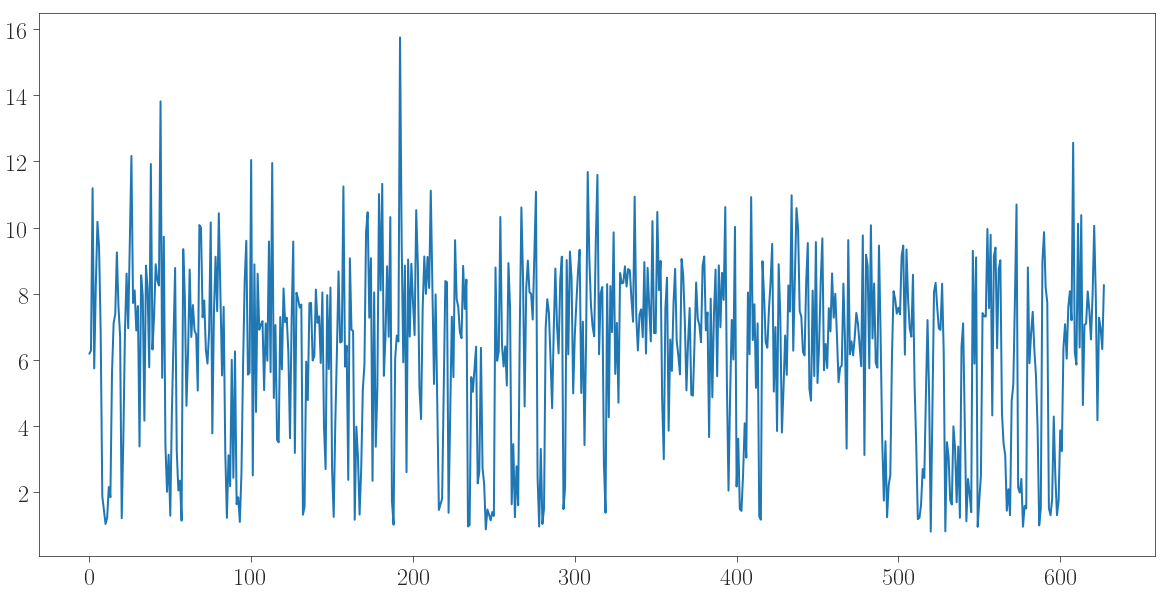

In [8]:
fig, ax = plt.subplots(figsize=(20, 10))
plt.plot(np.vstack(rmsd_profs)[::1000,2])

In [9]:
hist, bin_edges = np.histogram(rmsd_inst.rmsd[:,2], bins=50)

In [10]:
bin_labels = np.digitize(rmsd_inst.rmsd[:,2], bin_edges)

```python 
import MDAnalysis
from MDAnalysis.tests.datafiles import PDB, XTC

u = MDAnalysis.Universe(PDB, XTC)
protein = u.select_atoms("protein")
with MDAnalysis.Writer("protein.xtc", protein.n_atoms) as W:
    for ts in u.trajectory:
        W.write(protein)
```

In [11]:
np.unique(bin_labels, return_counts=True)

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
        35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 51]),
 array([ 24,  57,  50,  40,  63,  85, 162, 215, 260, 308, 421, 444, 495,
        573, 550, 563, 535, 460, 409, 360, 374, 270, 241, 228, 143, 115,
         82,  62,  58,  36,  31,  25,  31,  26,  15,  11,  17,  19,  10,
          6,   6,  11,   7,   1,   3,   1,   1,   1,   1,   1]))

In [12]:
hist

array([ 24,  57,  50,  40,  63,  85, 162, 215, 260, 308, 421, 444, 495,
       573, 550, 563, 535, 460, 409, 360, 374, 270, 241, 228, 143, 115,
        82,  62,  58,  36,  31,  25,  31,  26,  15,  11,  17,  19,  10,
         6,   6,  11,   7,   1,   3,   1,   1,   1,   1,   1])

In [13]:
with mda.Writer('VHP.pdb', mda_traj.atoms.n_atoms) as W: 
    for label in range(10, 50): 
        frame_indices = np.array(np.where(bin_labels == label+1)).flatten()
        # Number of frame to output 
        n_frame = np.round(hist[label]/float(sum(hist[10:])) * 100)
        for i in range(int(n_frame)): 
            label = np.random.choice(frame_indices) 
            mda_traj.trajectory[label] 
            W.write(mda_traj.atoms)
        

/Users/hm/anaconda2/lib/python2.7/site-packages/MDAnalysis/coordinates/base.py:837: UserWarning: Reader has no dt information, set to 1.0 ps
  warnings.warn("Reader has no dt information, set to 1.0 ps")


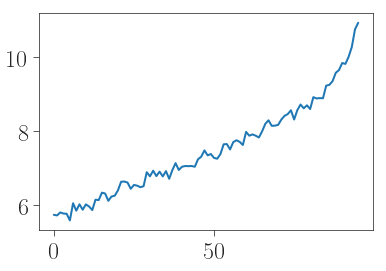

In [14]:
traj_file = 'VHP.pdb'
mda_traj = mda.Universe(pdb_file, traj_file) 
rmsd_inst = RMSD(mda_traj, ref_traj, select='protein and name CA') 
rmsd_inst.run()  

fig, ax = plt.subplots() 
ax.plot(rmsd_inst.rmsd[:,1], rmsd_inst.rmsd[:,2]) 

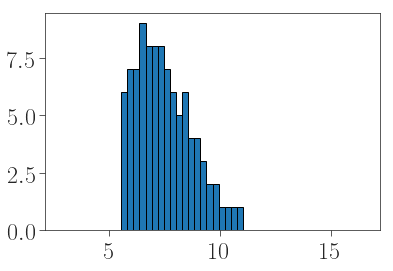

In [15]:
_ = plt.hist(rmsd_inst.rmsd[:,2], bins=bin_edges)

In [16]:
traj_dirs = sorted(glob.glob('../MD_exps/fs-pep/omm_runs_*'))

In [17]:
for traj_dir in traj_dirs[360:480]: 
    print os.listdir(traj_dir)

In [18]:
sum(np.round(hist[10:]/float(sum(hist[10:])) * 100))

96.0

In [19]:
from sklearn.decomposition import PCA
cm_pca = PCA(n_components=2).fit_transform(contact_matrices)

NameError: name 'contact_matrices' is not defined

In [ ]:
color = np.vstack(rmsd_profs)[:,2]
plt.scatter(cm_pca[:,0], cm_pca[:,1], c=color, cmap='jet', s=.5, alpha=.3)

In [ ]:
mda_traj = mda.Universe(pdb_file, traj_files) 

In [ ]:
len(mda_traj.trajectory)

In [ ]:
np.argmin(np.array(rmsd_inst.rmsd[:,2]))

In [ ]:
mda_traj.trajectory[0]

In [ ]:
mda_traj.atoms.write('vhp1ww.pdb')

In [ ]:
import simtk.openmm.app as app
import simtk.openmm as omm
import simtk.unit as u

import parmed as pmd

In [ ]:
top_file = '../MD_exps/VHP_exp/pdb/vhp1ww.top' 
pdb_file = '../MD_exps/VHP_exp/pdb/vhp1ww.pdb'

In [ ]:
pdb = pmd.load_file(top_file, xyz = pdb_file)

In [ ]:
app.PDBFile.writeFile(pdb.topology, mda_traj.atoms.positions - mda_traj.atoms.center_of_mass(), open('vhp1ww.pdb', 'w'))